**Определение возраста покупателей**

**Постановка задачи**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Содержание

Исследовательский анализ данных
- загрузка библиотек и инструментов
- загрузка датасета
- определение размеров датасета
- построение гистограммы распределения возрастов покупателей
- осмотр некоторых фотографий из датасета
- вывод по первому разделу
    
Обучение модели
- представление кода для обучения модели
- представление полученных метрик

Вывод по проекту

# Исследовательский анализ данных

## Загрузка необходимых библиотек и инструментов

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Загрузка исходного датасета

In [2]:
# Скачиваем исходный датасет

labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Произведем визуальный осмотр исходного датасета

labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
# Для дальнейшей работы с нейросетью создадим отдельный класс данных на основе скачанного датасета,
# при этом проведем его нормировку

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


## Определение размеров датасета

In [5]:
# Отделим признаки от целевого параметра с помощью функции next

features_train, target_train = next(train_gen_flow)

In [6]:
features_train.shape

(32, 224, 224, 3)

Исходные данные представляют собой набор из 32 изображений, каждое размером 224х224 пикселя, 3 цветовых канала. Плюс к этому имеется столбец с целевым признаком - возраст покупателя.

## Построение гистограммы распределения возраста покупателей

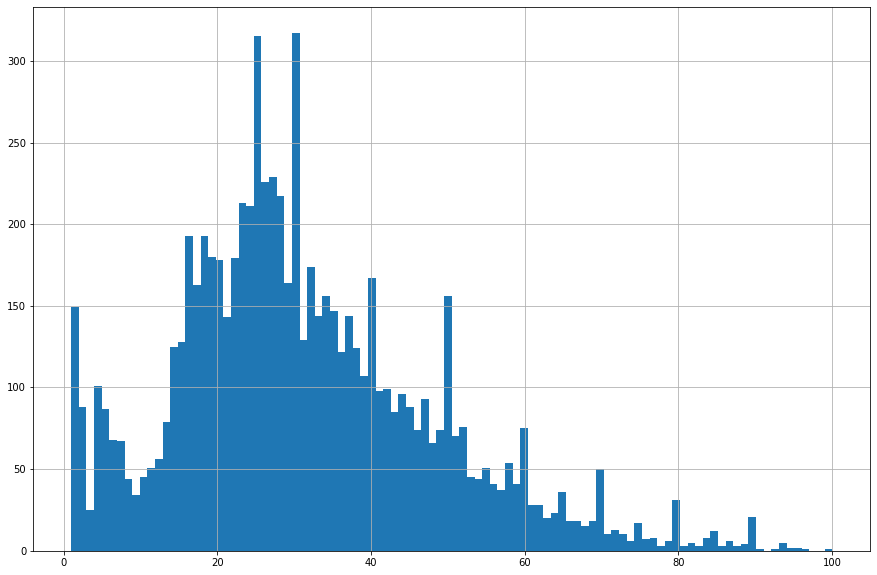

In [7]:
labels.real_age.hist(bins=100, figsize=(15,10))

Распределение возрастов покупателей своей формой стремится к нормальному виду. Полагаю, что при повышенииувеличении количества объектов данное сходство будет становиться более явным. 
    
Здесь наблюдается некоторое смещение датасета к значению в 30 лет (самое многочисленное). Видимо, это обусловлено тем, что этот возраст является самым активным в разрезе применения всяческих современных "фишек", которые и позволяют осуществлять контроль за параметрами клиента (карты лояльности, приложения магазина и т.д.). При этом явными пиками на гистограмме виднеются круглые даты. Думаю, что это может объясняться тем, что при разметке датасета неявные значения были округлены.
    
Интересным фактом является наличие среди покупателей значительного количества лиц, возраст которых менее 10, а то и 5 лет. При этом на 9, 10-летнем возрасте наблюдается просадка по численности, что не способствует повышению качества модели при работе по данному контингенту. Наверное, следует восполнить этот пробел путем добора данных по данной возрастной группе. 

## Осмотр имеющихся в датасете фотографий

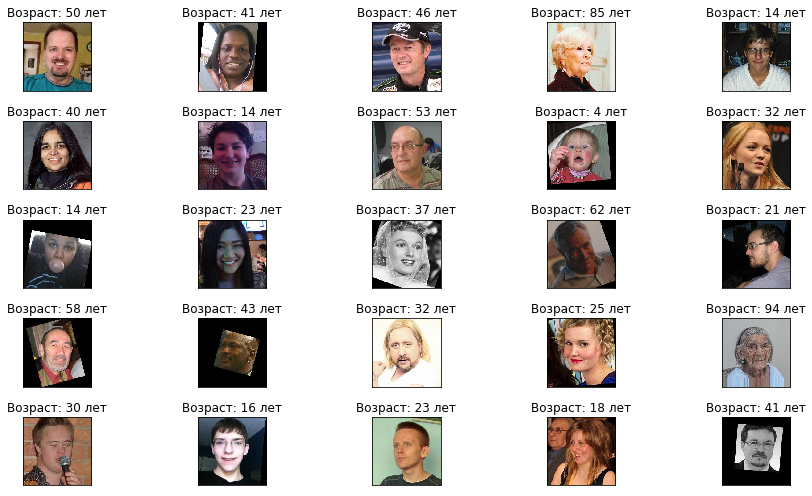

In [9]:
fig = plt.figure(figsize=(14,7))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features_train[i])
    plt.title('Возраст: {} лет'.format(target_train[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Проведен визуальный осмотр фотографий из датасета. На некоторых из них заметны следы аугментации - повороты (например, рис. 2, 9, 11).

## Вывод по первому разделу

В первом разделе работы проведена загрузка необходимых библиотек, инструментов и самих данных. Проведено построение распределения данных о возрасте покупателей, оценен размер датасета, осуществлен визуальный осмотр имеющихся фотографий.
    
Cам датасет можно оценить как маленький. Для того, чтобы достичь приемлемых уровней метрики MAE, нужно больше снимков. В качестве одного из решений данной проблемы без расширения количественного состава выборки можно применить различные виды аугментации (повороты, отражения, изменения яркости изображений). Сами фотографии в большинстве достаточно качественные, что позволит модели достаточно детально изучить особенности представленных лиц. Однако есть моменты, где человек изображен только в профиль или в черно-белом формате - это вряд ли поспособствует повышению метрик работы моделей.
    
Некоторые фотографии содержат более одного человека в кадре, что может привести к ошибочному выводу при рассмотрении снимка. В данном случае можно применять растягивание изображения, чтобы в кадре оставалось только нужное лицо. Да и вообще, одним из вариантом аугментации можно использовать уменьшение фотографий с крупным планом и, наоборот, увеличения фото покупателей, которые изображены мелко.

# Обучение модели

## Представление кода для обучения модели

```python
 
def load_train(path):
    labels = pd.read_csv(path+'/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 validation_split=0.25)
 
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path+'/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.25)
 
    valid_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return valid_datagen_flow
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0005)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=500, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, 
                  loss='mse',
                  metrics=['mae'])
 
    return model
 
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=15,
                steps_per_epoch=None, 
                validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

```

Данная модель показала свою работоспособность при обучении на сервере Яндекс

## Представление полученных по обучении метрик

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2021-11-07 09:46:26.836550: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-07 09:46:30.514508: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 124s - loss: 189.1467 - mae: 10.4328 - val_loss: 664.1534 - val_mae: 20.7658
Epoch 2/15
178/178 - 38s - loss: 119.0102 - mae: 8.3344 - val_loss: 571.4173 - val_mae: 18.8713
Epoch 3/15
178/178 - 38s - loss: 88.8836 - mae: 7.1175 - val_loss: 299.3720 - val_mae: 12.8942
Epoch 4/15
178/178 - 37s - loss: 71.1508 - mae: 6.3696 - val_loss: 204.9890 - val_mae: 10.6833
Epoch 5/15
178/178 - 38s - loss: 56.9864 - mae: 5.7803 - val_loss: 109.4680 - val_mae: 7.9180
Epoch 6/15
178/178 - 37s - loss: 47.4007 - mae: 5.2738 - val_loss: 92.7498 - val_mae: 7.4053
Epoch 7/15
178/178 - 37s - loss: 37.6208 - mae: 4.7011 - val_loss: 89.4211 - val_mae: 6.9853
Epoch 8/15
178/178 - 37s - loss: 33.4931 - mae: 4.3953 - val_loss: 87.4991 - val_mae: 6.9388
Epoch 9/15
178/178 - 37s - loss: 25.9600 - mae: 3.9100 - val_loss: 117.2150 - val_mae: 7.9012
Epoch 10/15
178/178 - 37s - loss: 21.0363 - mae: 3.5075 - val_loss: 76.5214 - val_mae: 6.7451
Epoch 11/15
178/178 - 37s - loss: 18.3700 - mae: 3.2601 - val_loss: 71.8462 - val_mae: 6.3745
Epoch 12/15
178/178 - 37s - loss: 15.2823 - mae: 2.9752 - val_loss: 76.1448 - val_mae: 6.6335
Epoch 13/15
178/178 - 37s - loss: 15.1150 - mae: 2.9613 - val_loss: 78.4305 - val_mae: 6.6815
Epoch 14/15
178/178 - 37s - loss: 14.0200 - mae: 2.8476 - val_loss: 71.5917 - val_mae: 6.5501
Epoch 15/15
178/178 - 37s - loss: 13.1864 - mae: 2.7709 - val_loss: 68.4711 - val_mae: 6.1896
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 68.4711 - mae: 6.1896
Test MAE: 6.1896

```

После 15 эпох обучения на валидационных данных удалось получить значение метрики MAE = 6.1896, что соответствует поставленным в задаче требованиям. Полагаю, что путем осуществления дополнительных действий (эксперименты с аугментацией и добавлением и настройой  слоев сети) данный показатель можно нарастить.  

# Вывод по проекту

В данной работе была произведена отработка навыков загрузки данных их предварительного анализа, формирования модели сверточной нейронной сети для оценки возраста покупателей по их фотографиям.

В результате был получен результат метрики MAE = 6.1896, что может позволить достаточно уверенно предлагать покупателям товары, которые могут им пригодиться. 

При этом определение добросовестности продавца при выдаче алкогольной продукции требует введения дополнительных условий. Так, если программа определяет возраст клиента в 25 лет и старше или 11 лет и младше, то вывод программы о добросовестности можно считать верным, так как такие граничные условия при полученной метрике позволяют однозначно сказать, разрешен ли доступ к алкоголю конкретному лицу. В случае, если покупателю от 11 до 25 лет, необходимо вручную проверять возраст клиента, так как программа в рамках погрешности не дает гарантии извлечения правильного вывода о соблюдении законодательства в этой сфере (к примеру, возраст 17-летнего подростка может быть определен на отрезке, примерно, от 11 до 23 лет).